In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz, butter
from scipy.io import wavfile
import warnings
warnings.filterwarnings('ignore')

# --- Parameters ---
fs = 16000  # Sampling frequency in Hz
duration = 3  # seconds
f0 = 120    # Fundamental frequency (pitch) in Hz, typical for a male voice
N = int(duration * fs) # Total number of samples

# --- Target Formants for vowel /a/ ---
f1, f2, f3 = 730, 1090, 2440
bw1, bw2, bw3 = 80, 90, 120 # Bandwidths

# --- Generate the Excitation Signal (Impulse Train for voiced speech) ---
t = np.arange(N) / fs
pitch_period_samples = int(fs / f0)
excitation = np.zeros(N)
excitation[::pitch_period_samples] = 1

# --- Generate the Vocal Tract Filter (Source-Filter Model) ---
# Create resonators for each formant
r1 = np.exp(-np.pi * bw1 / fs)
theta1 = 2 * np.pi * f1 / fs
a1 = np.array([1, -2 * r1 * np.cos(theta1), r1**2])

r2 = np.exp(-np.pi * bw2 / fs)
theta2 = 2 * np.pi * f2 / fs
a2 = np.array([1, -2 * r2 * np.cos(theta2), r2**2])

r3 = np.exp(-np.pi * bw3 / fs)
theta3 = 2 * np.pi * f3 / fs
a3 = np.array([1, -2 * r3 * np.cos(theta3), r3**2])

# Combine resonators by convolving their denominators
a_vowel = np.convolve(np.convolve(a1, a2), a3)
b_vowel = np.array([1.0])

# --- Synthesize the Speech Signal ---
original_signal = lfilter(b_vowel, a_vowel, excitation)
original_signal = original_signal / np.max(np.abs(original_signal)) # Normalize

print("Generated a 3-second speech signal for the vowel /a/.")
# Optional: Save the file
# wavfile.write("vowel_a_original.wav", fs, original_signal.astype(np.float32))

Generated a 3-second speech signal for the vowel /a/.


In [2]:
from scipy.linalg import toeplitz

def get_lpc_coeffs(signal_frame, p):
    """
    Calculates LPC coefficients using the autocorrelation method.
    p: LPC order
    """
    # Autocorrelation
    r = np.correlate(signal_frame, signal_frame, mode='full')
    r = r[len(signal_frame)-1 : len(signal_frame)+p]

    # Create Toeplitz matrix
    R = toeplitz(r[:p])

    # Solve Yule-Walker equations: R * a = r'
    r_prime = r[1:p+1]
    a = np.linalg.solve(R, r_prime)

    # Return as [1, -a1, -a2, ...] for filter representation
    return np.concatenate(([1], -a))

# --- LPC Analysis Parameters ---
frame_length_ms = 25
frame_shift_ms = 10
p_order = 18 # LPC order: rule of thumb is fs(kHz) + 2

frame_length_samples = int(frame_length_ms * fs / 1000)
frame_shift_samples = int(frame_shift_ms * fs / 1000)

# --- Pre-emphasis Filter ---
pre_emphasis_coeff = 0.97
emphasized_signal = lfilter([1, -pre_emphasis_coeff], [1], original_signal)

# --- Framing and Windowing ---
num_frames = 1 + int((N - frame_length_samples) / frame_shift_samples)
lpc_coeffs_matrix = []
residual_signal = np.zeros(N)

# We will analyze a single, representative frame from the middle of the signal
mid_point = N // 2
mid_frame_start = mid_point - frame_length_samples // 2
mid_frame_end = mid_point + frame_length_samples // 2
analysis_frame = emphasized_signal[mid_frame_start:mid_frame_end]
analysis_frame *= np.hamming(frame_length_samples)

# --- Extract LPC coefficients for the chosen frame ---
lpc_coeffs_a = get_lpc_coeffs(analysis_frame, p_order)
print(f"Extracted {p_order} LPC coefficients for a central frame.")

Extracted 18 LPC coefficients for a central frame.


In [3]:
# --- Calculate Residual for the whole signal ---
# We use the coefficients from our representative frame for simplicity
# In a full codec, coefficients would be updated for each frame
prediction = lfilter(-lpc_coeffs_a[1:], [1], emphasized_signal)
residual = emphasized_signal - prediction

# --- Reconstruct the signal from the residual ---
# De-emphasis is the inverse of pre-emphasis
reconstructed_signal_emphasized = lfilter([1], lpc_coeffs_a, residual)
reconstructed_signal = lfilter([1], [1, -pre_emphasis_coeff], reconstructed_signal_emphasized)

# Normalize for comparison
reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

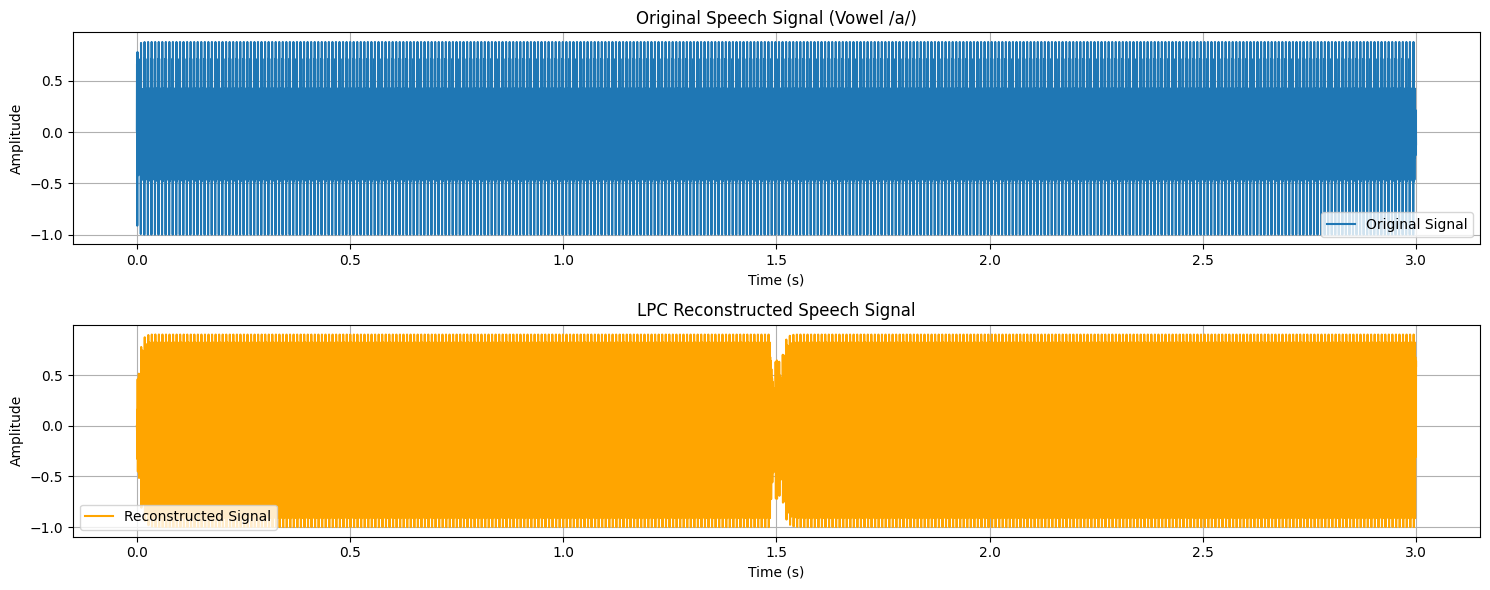

In [4]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title('Original Speech Signal (Vowel /a/)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_signal, label='Reconstructed Signal', color='orange')
plt.title('LPC Reconstructed Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
def find_formants(a, fs):
    """Finds formant frequencies from LPC coefficients."""
    roots = np.roots(a)
    # Keep roots with positive imaginary part and inside the unit circle
    roots = [r for r in roots if np.imag(r) >= 0]

    # Calculate angles and convert to frequency
    angles = np.angle(roots)
    freqs = sorted(angles * (fs / (2 * np.pi)))

    # Filter by bandwidth to avoid spurious peaks
    bandwidths = -0.5 * (fs / (2 * np.pi)) * np.log(np.abs(roots))
    formants = []
    for i, f in enumerate(freqs):
        if f > 80 and bandwidths[i] < 400: # Typical human formant range and bandwidth
            formants.append(f)

    return formants

# --- Estimate Formants from our LPC coefficients ---
estimated_formants = find_formants(lpc_coeffs_a, fs)
print("\nEstimated Formant Frequencies (Hz):")
for i, f in enumerate(estimated_formants[:3]):
    print(f"F{i+1}: {f:.2f}")


Estimated Formant Frequencies (Hz):
F1: 725.88
F2: 1078.46
F3: 1467.22


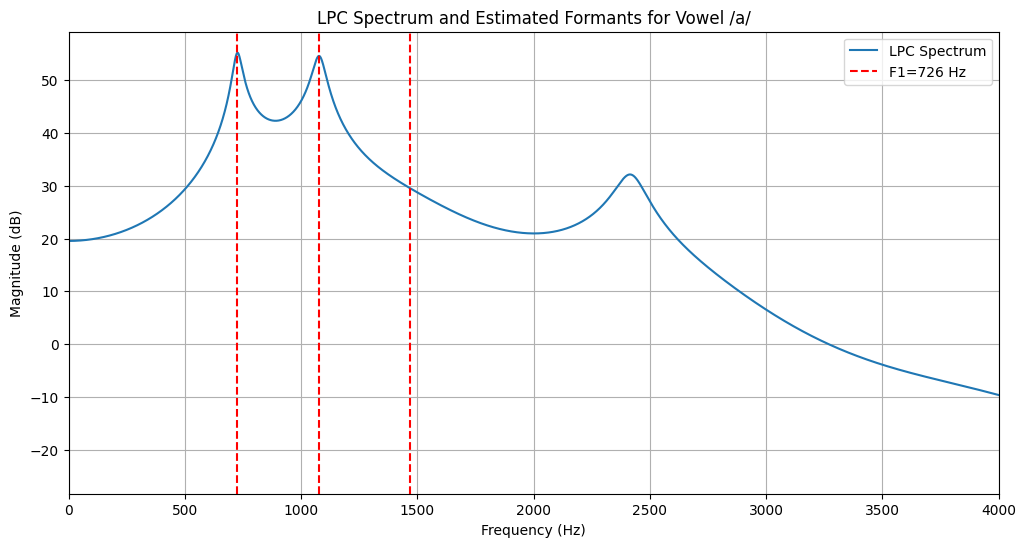

In [6]:
w, h = freqz([1], lpc_coeffs_a, worN=8000, fs=fs)
plt.figure(figsize=(12, 6))
plt.plot(w, 20 * np.log10(abs(h)), label='LPC Spectrum')
plt.title('LPC Spectrum and Estimated Formants for Vowel /a/')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)

# Mark the formants on the plot
for i, f in enumerate(estimated_formants[:3]):
    plt.axvline(x=f, color='r', linestyle='--', label=f'F{i+1}={f:.0f} Hz' if i==0 else f'_{f:.0f} Hz')

plt.legend()
plt.xlim(0, 4000)
plt.show()